In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from string import punctuation
import functools
from collections import defaultdict
from sklearn.metrics import accuracy_score

In [9]:
from datasets import load_dataset

dataset = load_dataset("imdb")

Found cached dataset imdb (/home/pierre/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

## The dataset

The IMDB sentiment dataset is a collection of 50K movie reviews, annotated as positive or negative, and split in two sets of equal size: a training and a test set. Both set have an equal number of positive and negative review. The dataset is available on several libraries, but we ask that you use the HuggingFace datasets version. Follow their tutorial on how to use the library for more details

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [11]:
# get info about the unsupervised splits
print(dataset["unsupervised"].info)

DatasetInfo(description='Large Movie Review Dataset.\nThis is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.', citation='@InProceedings{maas-EtAl:2011:ACL-HLT2011,\n  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},\n  title     = {Learning Word Vectors for Sentiment Analysis},\n  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},\n  month     = {June},\n  year      = {2011},\n  address   = {Portland, Oregon, USA},\n  publisher = {Association for Computational Linguistics},\n  pages     = {142--150},\n  url       = {http://www.aclweb.org/anthology/P11-1015}\n}\n', homepage='http://ai.stanford.edu/~amaas/data/sen

In [12]:
df_train = pd.DataFrame(dataset['train'])
df_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [13]:
df_test = pd.DataFrame(dataset['test'])
df_test

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [14]:
df_unsupervised = pd.DataFrame(dataset['unsupervised'])
df_unsupervised

,text,label
0,This is just a precious little diamond. The pl...,-1
1,When I say this is my favourite film of all ti...,-1
2,I saw this movie because I am a huge fan of th...,-1
3,Being that the only foreign films I usually li...,-1
4,After seeing Point of No Return (a great movie...,-1
...,...,...
49995,License To Kill (1989) is an inanely dismal in...,-1
49996,I love watching a James Bond. It's not very in...,-1
49997,I can't decide what was the worst thing about ...,-1
49998,UGH... As an adorer of the James Bond characte...,-1


(array([12500.,     0., 12500.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

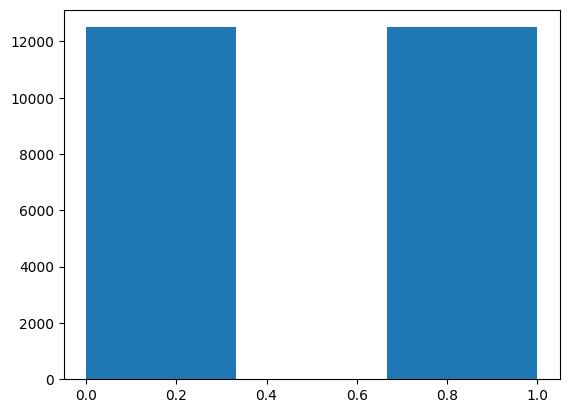

In [15]:
plt.hist(df_train['label'], bins=3)

In [16]:
labels = df_train["label"].unique()
labels

array([0, 1])

1) The dataset has 3 splits

2) The train and test splits have 25000 rows, and the unsupervised split has 50000 rows.


In [17]:
for label in labels:
    print(f"Nombre de sample de la classe {label} dans train\
             {df_train[df_train['label'] == label].shape[0]}")
    print(f"Nombre de sample de la classe {label} dans test\
             {df_train[df_train['label'] == label].shape[0]}")

Nombre de sample de la classe 0 dans train             12500
Nombre de sample de la classe 0 dans test             12500
Nombre de sample de la classe 1 dans train             12500
Nombre de sample de la classe 1 dans test             12500


3) Chaque classe dans les datasets supervisés sont de 12 500

## Naive Bayes classifier


#### Preprocessing

In [18]:
for i in range(10):   
    print(f"{df_train['text'][i]}\n")

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

Texts contain some html like "<br \/>" or punctuations which are not necessary. <br> Let remove them.

In [19]:
def PreprocessingString(text):
    text = text.lower()
    
    text = text.replace("<br />", " ")
    for punct in punctuation:
        if (not punct in str("\'-")):
            text = text.replace(punct, " ")

    return text

In [20]:
print(PreprocessingString(df_train['text'][0]))

i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967  i also heard that at first it was seized by u s  customs if it ever tried to enter this country  therefore being a fan of films considered  controversial  i really had to see this for myself   the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life  in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states  in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men   what kills me about i am curious-yellow is that 40 years ago  this was considered pornographic  really  the sex and nudity scenes are few and far between  even then it's not shot

In [21]:
df_train['text'] = df_train['text'].apply(lambda x: PreprocessingString(x))
df_train

,text,label
0,i rented i am curious-yellow from my video sto...,0
1,i am curious yellow is a risible and preten...,0
2,if only to avoid making this type of film in t...,0
3,this film was probably inspired by godard's ma...,0
4,oh brother after hearing about this ridicul...,0
...,...,...
24995,a hit at the time but now better categorised a...,1
24996,i love this movie like no other another time ...,1
24997,this film and it's sequel barry mckenzie holds...,1
24998,'the adventures of barry mckenzie' started lif...,1


In [22]:
%time vocabulary = set(str().join((df_train['text'])).split(" "))
#%time voc2 = np.unique(np.concatenate([text.split(" ") for text in df_train['text'].tolist()]))
#%time voc3 = functools.reduce(lambda a, b: a + b, df_train['text'].values)

CPU times: user 369 ms, sys: 105 ms, total: 474 ms
Wall time: 473 ms


#### Naive Bayes from Scratch

In [30]:
def TrainNaiveBayes(df, document, classes):
    log_prior = []
    loglikehood = []
    vocabulary = set(str().join((df['text'])).split(" "))
    n_doc = len(document)
    
    for class_c in classes:
        n_class = df[df['label'] == class_c].shape[0]
        log_prior.append(np.log(n_class / n_doc))
        
        big_doc = str().join((df[df['label'] == class_c]['text'])).split(" ")
        d = defaultdict(int)
        for word in big_doc:
           d[word] += 1 
        sumcount_v = sum(d.values()) + len(vocabulary)
        
        loglikehood_c = {}
        
        for word in vocabulary:
            loglikehood_c[word] = np.log((d[word] + 1) / sumcount_v)
        loglikehood.append(loglikehood_c)
    
    return log_prior, loglikehood, vocabulary

In [31]:
%time logprior, loglikehood, vocabulary = TrainNaiveBayes(df_train, list(df_train['text']), [0, 1])

CPU times: user 1.41 s, sys: 82.9 ms, total: 1.49 s
Wall time: 1.49 s


In [32]:
def TestNaiveBayes(testdoc, logprior, loglikehood, classes, vocabulary):
    probabilty_class = {}
    for classes_c in classes:
        probabilty_class[classes_c] = logprior[classes_c]
        for word in testdoc.split():
            if (word in vocabulary):
                probabilty_class[classes_c] += loglikehood[classes_c][word]
    return np.argmax(list(probabilty_class.values()))

In [33]:
y_pred = df_test['text'].apply(lambda x : TestNaiveBayes(x, logprior, loglikehood, [0, 1], vocabulary))
y_true = df_test['label']
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.81624

#### Naive Bayes from Scikit-learn

In [34]:
# bayes classifier with sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train['text'])
X_train_counts.shape

clf = MultinomialNB().fit(X_train_counts, df_train['label'])

X_test_counts = count_vect.transform(df_test['text'])
y_pred = clf.predict(X_test_counts)
y_true = df_test['label']
accuracy = accuracy_score(y_true, y_pred)
accuracy
 

0.81768